# Generative Adversarial Networks
**Generative Adversarial Networks** or GANs - use neural networks for Generative modeling.

> **Generative modeling** is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.



While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach: 

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

There are two neural networks: a **Generator** and a **Discriminator**. The generator generates a "fake" sample given a random input vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their job.

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization.

We'll train a GAN to generate images of handwritten digits similar to those from the MNIST database.

<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >


* Define the problem statement
* Load the data (with transforms and normalization)
    * Denormalize for visual inspection of samples
* Define the Discriminator network
    * Study the activation function: Leaky ReLU
* Define the Generator network
    * Explain the output activation function: tanh
    * Look at some sample outputs
* Define losses, optimizers and helper functions for training
    * For discriminator
    * For generator
* Train the model
    * Save intermediate generated images to file
* Look at outputs
* Save the models

## Load the Data

Download and import the data as a PyTorch dataset using the `MNIST` helper class from `torchvision.datasets`.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. Let's look at a sample tensor from the data.

In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

The pixel values are in the range (-1,1). We will now define a helper function to denormalize and view the images. We will also use this for viewing the generated images.

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


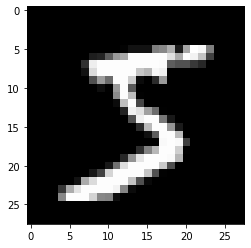

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Create a dataloader to load the images in batches.

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([9, 7, 7, 2, 1, 5, 3, 0, 5, 5, 1, 1, 7, 1, 8, 2, 2, 9, 6, 0, 6, 1, 0, 7,
        5, 2, 1, 4, 9, 3, 6, 0, 7, 7, 6, 3, 9, 8, 2, 9, 2, 3, 9, 1, 5, 1, 9, 1,
        9, 2, 1, 9, 4, 7, 4, 5, 3, 7, 3, 1, 6, 0, 3, 7, 8, 6, 1, 3, 8, 1, 0, 5,
        7, 0, 2, 7, 6, 0, 7, 7, 9, 2, 9, 3, 5, 9, 8, 9, 2, 7, 6, 3, 9, 2, 6, 7,
        0, 7, 0, 6])


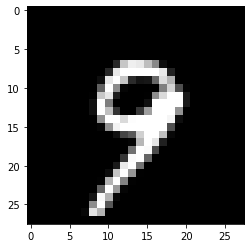

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Discriminator Network

The Discriminator takes an image as input, and tries to classify it as "real" or "generated/fake". It's like any other neural network - while we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers. 

Each 28x28 image is viewed as a vector of size 784.

In [8]:
image_size = 784
hidden_size = 256

In [9]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

We are using the Leaky ReLU activation for the discriminator.

We need to move the discriminator model to the device.

In [10]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. We'll use a feed-forward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [11]:
latent_size = 64

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

We are using the **tanh** activation function in the generator.

[Reference](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)
> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling."

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

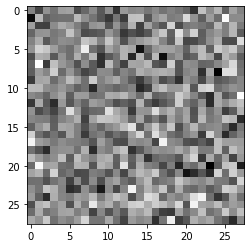

In [14]:
plt.imshow(gen_imgs[0], cmap='gray');

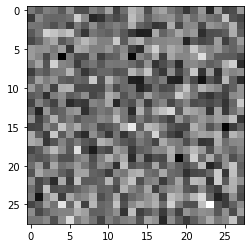

In [15]:
plt.imshow(gen_imgs[1], cmap='gray');

In [16]:
G.to(device);

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy (**BCE**) loss function to quantify how well it is able to differentiate between real and generated images.

In [17]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

Define helper functions to reset gradients and to train the discriminator.

In [18]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

We don't change the weights of the generator model while training the discriminator and vice versa.

## Generator Training

In training the generator, we use the discriminator as a part of the loss function:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator i.e., generator has to generate such images which the discriminator thinks are real.

- We use the loss to perform gradient descent i.e. change the weights of the generator model, and it gets better at generating real-like images.


In [19]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [20]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model

Create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model.

In [21]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Save a batch of real images that we can use for visual comparision while looking at the generated images.

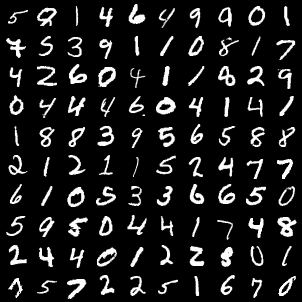

In [22]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator, to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


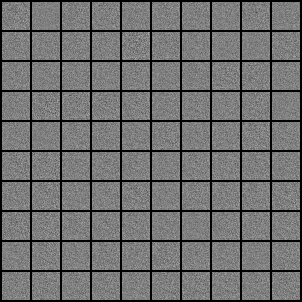

In [23]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We now train the model. In each epoch, we train the discriminator first, and then the generator.

In [24]:
%%time
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0462, g_loss: 4.2182, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.6804, g_loss: 4.9472, D(x): 0.86, D(G(z)): 0.27
Epoch [0/300], Step [600/600], d_loss: 0.0910, g_loss: 4.5781, D(x): 0.95, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1554, g_loss: 3.4990, D(x): 0.95, D(G(z)): 0.09
Epoch [1/300], Step [400/600], d_loss: 0.1217, g_loss: 4.7666, D(x): 0.97, D(G(z)): 0.07
Epoch [1/300], Step [600/600], d_loss: 0.3538, g_loss: 6.5052, D(x): 0.86, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3332, g_loss: 2.8678, D(x): 0.89, D(G(z)): 0.11
Epoch [2/300], Step [400/600], d_loss: 0.4463, g_loss: 2.7562, D(x): 0.79, D(G(z)): 0.05
Epoch [2/300], Step [600/600], d_loss: 0.2974, g_loss: 2.6916, D(x): 0.90, D(G(z)): 0.12
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2838, g_loss: 3.1712, D(x): 0.90, D(G(z)): 0.08
Epoch [3/300], Step [400/6

In [25]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

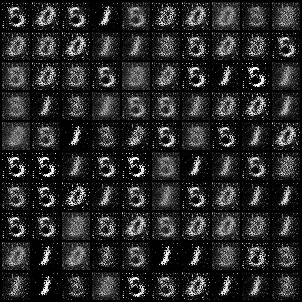

In [26]:
Image('./samples/fake_images-0010.png')

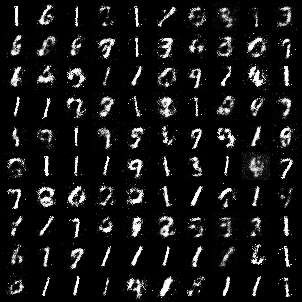

In [27]:
Image('./samples/fake_images-0050.png')

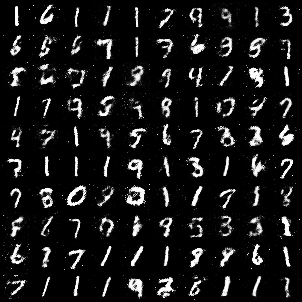

In [28]:
Image('./samples/fake_images-0100.png')

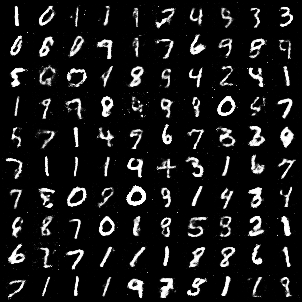

In [29]:
Image('./samples/fake_images-0200.png')

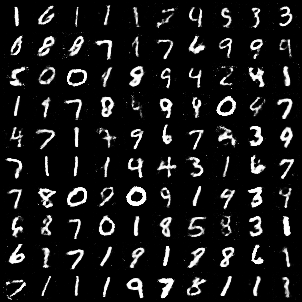

In [30]:
Image('./samples/fake_images-0300.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [31]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

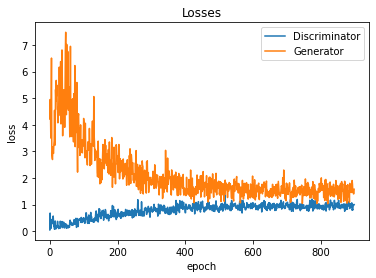

In [32]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

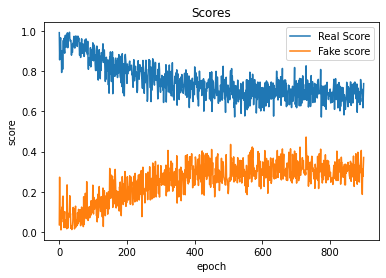

In [33]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');